In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from umap import UMAP
import plotly.express as px
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder

In [3]:
male_players = pd.read_csv('data/male_players.csv')
male_players

C:\Users\akhil\AppData\Local\Temp\ipykernel_16440\2510204913.py:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  male_players = pd.read_csv('data/male_players.csv')


,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,2023-09-22,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,https://sofifa.com/player/220806/ellis-redman/...,15.0,2.0,2014-09-18,E. Redman,Ellis Redman,CB,41,61,...,38,38,38,37,40,41,41,41,40,10
180017,225509,https://sofifa.com/player/225509/aaron-collins...,15.0,2.0,2014-09-18,A. Collins,Aaron Graham John Collins,ST,41,50,...,30,30,30,31,32,31,31,31,32,14
180018,217591,https://sofifa.com/player/217591/piotr-zemlo/1...,15.0,2.0,2014-09-18,P. Żemło,Piotr Żemło,"LM, LB",40,50,...,46,46,46,48,51-1,53-3,53-3,53-3,51-1,12
180019,222947,https://sofifa.com/player/222947/tom-davies/15...,15.0,2.0,2014-09-18,T. Davies,Thomas Christopher Davies,CB,40,49,...,36,36,36,37,39,40,40,40,39,13


### EDA

In [4]:
# drop the columns that are unrelevant to our anaylsis
male_players = male_players.drop(['player_url','short_name', 'long_name',
                                  'potential','value_eur','wage_eur','age',
                                  'dob','club_team_id','club_name','league_id',
                                  'league_name','league_level','club_position','club_jersey_number',
                                  'club_loaned_from','club_joined_date','club_contract_valid_until_year',
                                  'nationality_id','nationality_name', 'nation_team_id','nation_position',
                                  'nation_jersey_number','international_reputation','body_type','real_face',
                                  'release_clause_eur','player_tags','player_traits', 'fifa_update', 'goalkeeping_speed',
                                    'shooting', 'passing', 'physic', 'defending', 'dribbling', 'pace', 'mentality_composure'], axis = 1)
male_players

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,15.0,2014-09-18,CB,41,187,81,Right,2,2,...,38,38,38,37,40,41,41,41,40,10
180017,225509,15.0,2014-09-18,ST,41,178,57,Right,3,3,...,30,30,30,31,32,31,31,31,32,14
180018,217591,15.0,2014-09-18,"LM, LB",40,190,76,Left,3,2,...,46,46,46,48,51-1,53-3,53-3,53-3,51-1,12
180019,222947,15.0,2014-09-18,CB,40,180,70,Right,2,2,...,36,36,36,37,39,40,40,40,39,13


In [5]:
pd.set_option('display.max_rows', 10)
male_players_24 = male_players[male_players['fifa_version'] == 24.0]
male_players_24 

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,273759,24.0,2023-09-22,CB,47,176,76,Left,3,2,...,39+2,39+2,39+2,41+2,43+2,47+2,47+2,47+2,43+2,13+2
18346,269013,24.0,2023-09-22,CB,47,183,74,Right,3,2,...,43+2,43+2,43+2,44+2,46+2,47+2,47+2,47+2,46+2,13+2
18347,272748,24.0,2023-09-22,ST,47,184,65,Right,2,2,...,31+2,31+2,31+2,35+2,33+2,27+2,27+2,27+2,33+2,13+2
18348,269534,24.0,2023-09-22,CM,47,178,74,Right,3,2,...,45+2,45+2,45+2,45+2,45+2,44+2,44+2,44+2,45+2,14+2


In [6]:
# check if any na values still remain
missing = male_players.isna().sum()
missing.sort_values(ascending= False)

player_id                0
st                       0
rw                       0
rf                       0
cf                       0
                        ..
movement_agility         0
movement_sprint_speed    0
movement_acceleration    0
skill_ball_control       0
gk                       0
Length: 71, dtype: int64

In [7]:
# define broad categories
defender_positions = {'CB', 'LB', 'RB', 'LWB', 'RWB', 'DB'}
midfielder_positions = {'CM', 'CAM', 'CDM', 'LM', 'RM'}
forward_positions = {'CF', 'ST', 'LW', 'RW'}
goalkeeper_position = {'GK'}

In [8]:
def generalize_position(position):
    positions = position.replace(' ', '').split(',')
    for pos in positions:
        if pos in goalkeeper_position:
            return 'GK'
        elif pos in defender_positions:
            return 'D'
        elif pos in midfielder_positions:
            return 'M'
        elif pos in forward_positions:
            return 'F'
    return 'Unknown'

In [9]:
# Apply function to player positions
male_players_24['broad_position'] = male_players_24['player_positions'].apply(generalize_position)

male_players_24['broad_position'].unique()

C:\Users\akhil\AppData\Local\Temp\ipykernel_16440\1509442758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_players_24['broad_position'] = male_players_24['player_positions'].apply(generalize_position)


array(['F', 'M', 'GK', 'D'], dtype=object)

In [10]:
male_players_24.dtypes[::-1][:10]

broad_position    object
gk                object
rb                object
rcb               object
cb                object
lcb               object
lb                object
rwb               object
rdm               object
cdm               object
dtype: object

In [11]:
# remove + or - symbols in player's stats
male_players_24 = male_players_24.copy()

def remove_symbols_and_convert_int(value):
    value = str(value)
    if pd.isna(value):
        return np.nan
    # split the string at '+' or '-' and convert to integer
    for char in ['+', '-']:
        if char in value:
            return int(value.split(char)[0])
    # if neither '+' nor '-' is in the value, just convert it to integer
    return int(value)

columns_to_process = ['ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

for column in columns_to_process:
    male_players_24.loc[:, column] = male_players_24[column].apply(remove_symbols_and_convert_int)

male_players_24

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,broad_position
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63,63,68,63,54,54,54,63,18,F
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63,63,62,60,62,62,62,60,19,F
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80,80,79,75,70,70,70,75,21,M
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63,63,64,59,49,49,49,59,19,F
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64,64,64,60,55,55,55,60,18,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,273759,24.0,2023-09-22,CB,47,176,76,Left,3,2,...,39,39,41,43,47,47,47,43,13,D
18346,269013,24.0,2023-09-22,CB,47,183,74,Right,3,2,...,43,43,44,46,47,47,47,46,13,D
18347,272748,24.0,2023-09-22,ST,47,184,65,Right,2,2,...,31,31,35,33,27,27,27,33,13,F
18348,269534,24.0,2023-09-22,CM,47,178,74,Right,3,2,...,45,45,45,45,44,44,44,45,14,M


In [12]:
# number of players in each position's
male_players_24.groupby('broad_position')['player_id'].count()

broad_position
D     6174
F     3458
GK    2045
M     6673
Name: player_id, dtype: int64

In [13]:
attributes=['lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram']

# Melting the DataFrame to have attribute names in a single column and their values in another
melted_df = male_players_24.melt(id_vars=['broad_position'], value_vars=attributes, var_name='Attribute', value_name='Value')
melted_df

,broad_position,Attribute,Value
0,F,lw,91
1,F,lw,82
2,M,lw,87
3,F,lw,90
4,F,lw,86
...,...,...,...
146795,D,ram,28
146796,D,ram,33
146797,F,ram,45
146798,M,ram,47


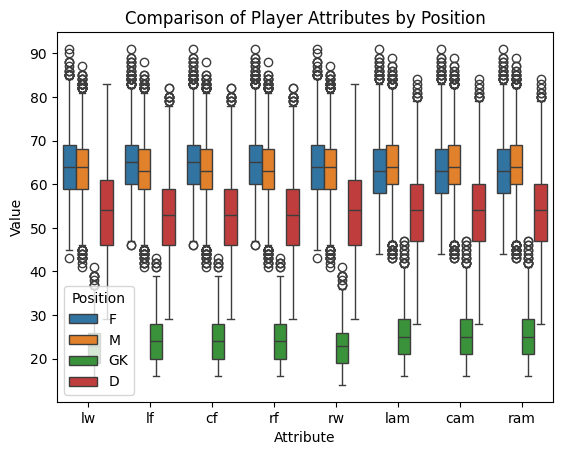

In [14]:
# boxplot of each position's attributes
sns.boxplot(data=melted_df, x='Attribute', y='Value', hue='broad_position')
plt.title('Comparison of Player Attributes by Position')
plt.xlabel('Attribute')
plt.ylabel('Value')
plt.legend(title='Position')
plt.show()

In [15]:
# correlation matrix
corr_matrix = male_players_24[attributes].corr()
corr_matrix

,lw,lf,cf,rf,rw,lam,cam,ram
lw,1.000000,0.994407,0.994407,0.994407,1.000000,0.992693,0.992693,0.992693
lf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
cf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
rf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
rw,1.000000,0.994407,0.994407,0.994407,1.000000,0.992693,0.992693,0.992693
lam,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000
cam,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000
ram,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000


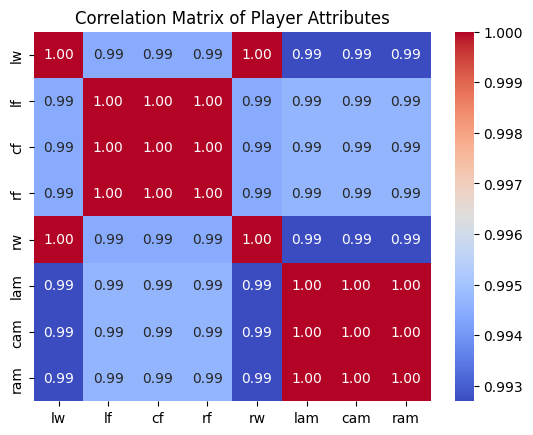

In [16]:
# heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm') # square=True, linewidths=.5, cbar_kws={"shrink": .5}
plt.title('Correlation Matrix of Player Attributes')
plt.show()

In [17]:
male_players_24.to_csv('male_players_preprocessed.csv', index=False)